In [38]:
import sys
from pathlib import Path

Reloading 'chequeparser.integrations.paddleocr'.


In [39]:
# !{sys.executable} -m pip install efficient-ocr

In [40]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## imports

In [41]:
from chequeparser.wrappers.detection_results import DetectionResults
from chequeparser.wrappers.bbox import BBox
from chequeparser.utilities.ds_utils import concat_ds

In [42]:
from chequeparser.datasets.fileds import FileDS
from chequeparser.datasets.imageds import ImageDS

In [43]:
from chequeparser.models import UL_RTDETR, DOCTR_DB_RESNET50, DOCTR_CRNN_VGG16, GCV_OCR, PPOCR_DBNET, PPOCR_SVTR_LCNET
from chequeparser.core.detector import detect
from chequeparser.core.recognizer import recognize

In [44]:
from chequeparser.utilities.misc_utils import partition_list

## config

In [45]:
dir_images = "../data/public/images"

## prep ds

In [70]:
file_ds = FileDS(dir_images)

  0%|          | 0/236 [00:00<?, ?it/s]

2024-02-26 23:44:55.434 | INFO     | chequeparser.utilities.io_utils:get_files:57 - Found 235 files.


In [78]:
mini_ds = file_ds.get_as_ds(slice(3, -1))

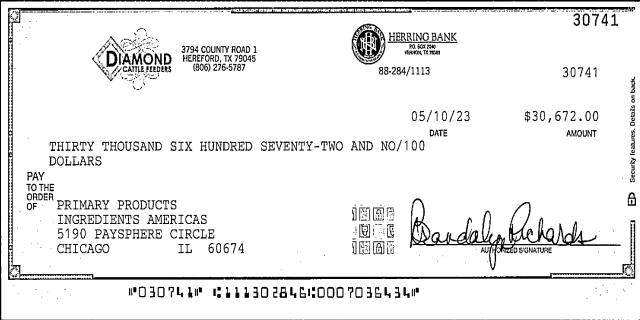

In [79]:
mini_ds[0]

## test refactoring

In [80]:
words_model = DOCTR_DB_RESNET50(symmetric_pad=True, preserve_aspect_ratio=True)

2024-02-26 23:45:34.683 | INFO     | chequeparser.wrappers.model:__init__:22 - Loaded model from pretrained dir, to cpu


In [81]:
rec_model = PPOCR_SVTR_LCNET()

2024-02-26 23:45:34.719 | INFO     | chequeparser.utilities.network_utils:download_file:85 - Found /home/ajkdrag/.cache/ppocr/models/en_PP-OCRv4_rec_infer.tar. Skipping download.
2024-02-26 23:45:34.720 | INFO     | chequeparser.utilities.network_utils:download_file:106 - Found /home/ajkdrag/.cache/ppocr/models/en_PP-OCRv4_rec_infer. Skipping untar.
2024-02-26 23:45:34.722 | INFO     | chequeparser.integrations.paddleocr:load:101 - Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir=None, cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir=None, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, de

In [82]:
words = detect(words_model, mini_ds.batch(), device="cpu", verbose=False, stream=False)

In [89]:
filtered = [word.filter_by_region(0, 0.2, 1, 0.5) for word in words]

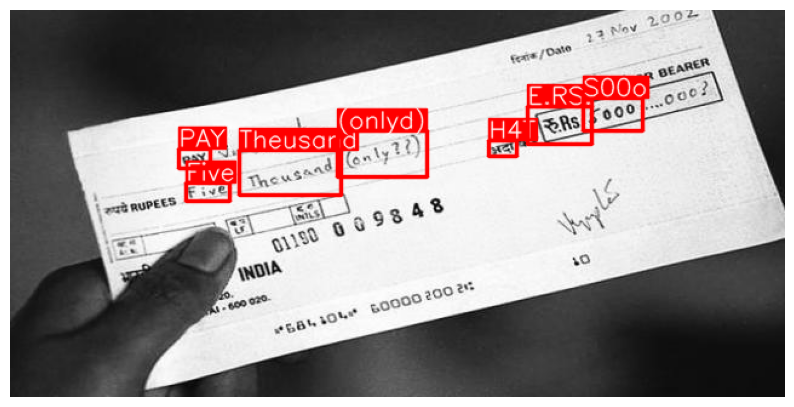

In [95]:
filtered[2].draw(mini_ds, show_text=True)

In [61]:
from tqdm.autonotebook import tqdm

In [83]:
for words_dets in tqdm(words):
    temp_ds = words_dets.create_ds(mini_ds)
    temp_ds.batched = True
    l_recs = recognize(rec_model, temp_ds, stream=False, verbose=False)
    _ = [box.set_text_and_confidence(rec_results)
     for box, rec_results in zip(words_dets.bboxes, l_recs)]

  0%|          | 0/4 [00:00<?, ?it/s]

In [79]:
mini_rec_ds = rois[0].create_ds(mini_ds)
mini_rec_ds.batched = True

In [94]:
mini_rec_ds[3]

In [102]:
rec_results = recognize(model, mini_rec_ds, stream=False)

Reloading 'chequeparser.integrations.paddleocr'.


2024-02-26 19:48:08.351 | INFO     | chequeparser.core.recognizer:recognize:30 - Stream mode: False
2024-02-26 19:48:08.352 | INFO     | chequeparser.core.recognizer:recognize:31 - Batched mode: True
2024-02-26 19:48:08.353 | INFO     | chequeparser.core.recognizer:recognize:32 - Running predict on 5 samples
2024-02-26 19:48:08.513 | DEBUG    | chequeparser.integrations.paddleocr:_predict:29 - [('02122016', 0.9866495132446289), ('0260000200024240029', 0.9434717893600464), ('SELF', 0.9935069680213928), ('5000-', 0.8739107251167297), ('PAY', 0.985064685344696)]


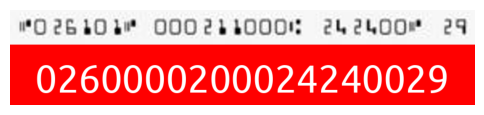

In [107]:
rec_results[1].draw(mini_rec_ds)

In [38]:
import pandas as pd

In [39]:
pd.DataFrame(results[0].to_numpy(include_meta=True)[..., [-3, -4]])

,0,1
0,0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d...,0
1,0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d...,0
2,0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d...,0
3,0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d...,0
4,0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d...,0
5,0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d...,0
6,0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d...,0
7,0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d...,0
8,0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d...,0
9,0ac815b8-59_jpg.rf.ae9679aa9bd29656b8aecad937d...,0


In [41]:
from typing import Union, List, Tuple

In [121]:
import pandas as pd
from typing import List, Tuple, Union

def compare_dataframes(df_a: pd.DataFrame, df_b: pd.DataFrame, index_a: str, index_b: str, cols_to_compare: Union[List, List[Tuple]], how: str) -> pd.DataFrame:
    """
    Compare two dataframes based on specified indices and columns.

    Args:
        df_a (pd.DataFrame): First dataframe to compare.
        df_b (pd.DataFrame): Second dataframe to compare.
        index_a (str): Name of the index column in df_a.
        index_b (str): Name of the index column in df_b.
        cols_to_compare (Union[List, List[Tuple]]): List of column names to compare or list of tuples specifying column names for each dataframe.
        how (str): Comparison method. Can be "inner", "left", or "right".

    Returns:
        pd.DataFrame: DataFrame containing comparison results as percentage of matches.
    """
    # Check if indices are named and assign names if not
    if df_a.index.name is None:
        df_a.index.name = index_a
    if df_b.index.name is None:
        df_b.index.name = index_b

    # Set indices if they are not already set
    if index_a != df_a.index.name:
        df_a = df_a.set_index(index_a)
    if index_b != df_b.index.name:
        df_b = df_b.set_index(index_b)

    if isinstance(cols_to_compare[0], tuple):
        cols_a, cols_b = map(list, zip(*cols_to_compare))
        print(cols_a)
    else:
        cols_a, cols_b = cols_to_compare, cols_to_compare

    # Ensure correct column names after merge operation
    cols_a_merged = [col + '_a' for col in cols_a]
    cols_b_merged = [col + '_b' for col in cols_b]

    comparison_results = df_a[cols_a].merge(df_b[cols_b], how=how, left_index=True, right_index=True, suffixes=('_a', '_b'))
    match_percentages = {}
    for col_a, col_b in zip(cols_a_merged, cols_b_merged):
        matches = (comparison_results[col_a] == comparison_results[col_b]).mean() * 100
        match_percentages[col_a[:-2]] = f"{matches:.2f}%"

    return pd.DataFrame(match_percentages, index=['Match Percentage'])

# Example usage:
# result = compare_dataframes(df_a, df_b, 'index_a', 'index_b', [('col1_a', 'col1_b'), ('col2_a', 'col2_b')], 'inner')
# print(result)


In [122]:
cols_to_compare = [("A", "B")]


In [123]:
cols_a, cols_b = map(list, zip(*cols_to_compare))

In [124]:
cols_a

['A']

In [125]:
import numpy as np
np.random.seed(0)
df_a = pd.DataFrame(np.random.randint(0, 10, size=(5, 3)), columns=['A', 'B', 'C'], index=['idx1', 'idx2', 'idx3', 'idx4', 'idx5'])
df_b = pd.DataFrame(np.random.randint(0, 10, size=(5, 3)), columns=['C', 'A', 'B'], index=['idx3', 'idx4', 'idx5', 'idx6', 'idx7'])

# Display the generated dataframes
print("DataFrame A:")
print(df_a)
print("\nDataFrame B:")
print(df_b)

DataFrame A:
      A  B  C
idx1  5  0  3
idx2  3  7  9
idx3  3  5  2
idx4  4  7  6
idx5  8  8  1

DataFrame B:
      C  A  B
idx3  6  7  7
idx4  8  1  5
idx5  9  8  9
idx6  4  3  0
idx7  3  5  0


In [126]:
compare_dataframes(df_a, df_b, index_a="indexa", index_b="indexb", how="left", cols_to_compare=[("A", "A")])

['A']


,A
Match Percentage,20.00%


## test e2e

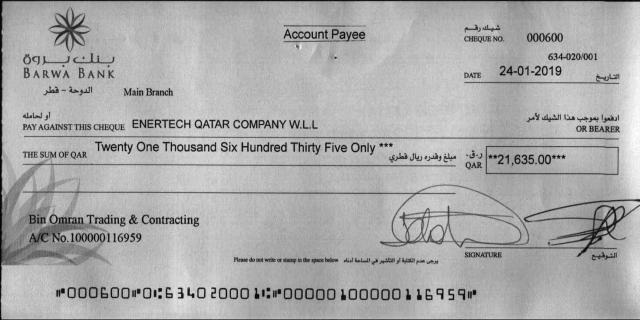

In [82]:
one_ds[0]

In [83]:
e2e_model = ocr_predictor(pretrained=True)

In [92]:
e2e_model.det_predictor.model.postprocessor.box_thresh = 0.2
e2e_model.det_predictor.model.postprocessor.bin_thresh = 0.5


In [93]:
e2e_res = e2e_model([np.array(one_ds[0])])

In [94]:
e2e_res.pages[0].blocks

[Block(
   (lines): [
     Line(
       (words): [Word(value='1', confidence=0.72)]
     ),
     Line(
       (words): [
         Word(value='HEQUENO,', confidence=0.81),
         Word(value='000600', confidence=1.0),
       ]
     ),
   ]
   (artefacts): []
 ),
 Block(
   (lines): [Line(
     (words): [
       Word(value='Account', confidence=1.0),
       Word(value='Payee', confidence=1.0),
     ]
   )]
   (artefacts): []
 ),
 Block(
   (lines): [
     Line(
       (words): [
         Word(value='O9', confidence=0.39),
         Word(value='Jcli', confidence=0.28),
       ]
     ),
     Line(
       (words): [
         Word(value='BARWA', confidence=1.0),
         Word(value='BANK', confidence=1.0),
       ]
     ),
     Line(
       (words): [Word(value='-layl', confidence=0.32)]
     ),
   ]
   (artefacts): []
 ),
 Block(
   (lines): [Line(
     (words): [Word(value='634-020/001', confidence=0.65)]
   )]
   (artefacts): []
 ),
 Block(
   (lines): [Line(
     (words): [
       Word(v

In [80]:
e2e_res.pages[0].blocks[0].render().splitlines()

['DUNLAP COMMUNITY UNIT 03-71',
 'DIST. 323 ACTIVITY FUND',
 'DUNLAP HIGH SCHOOL',
 '5220W.LEGON HALLRD.',
 'DUNLAP, IL 61525',
 'Pay to the',
 'Orderof.']

## test pkg

  0%|          | 0/370 [00:00<?, ?it/s]

2024-02-15 11:04:22.217 | INFO     | chequeparser.utilities.io_utils:get_image_files:31 - Found 369 image files.


In [76]:
model = UltralyticsDetect("../pretrained/best.pt", arch=UL_RTDETR)

In [194]:
doctr_det_arch_config = {
    "preserve_aspect_ratio": True,
    "symmetric_pad": True
}
det_model_doctr = DoctrDetect(path="db_resnet50", arch=DOCTR_DETECT_PRETRAINED, arch_config = doctr_det_arch_config)

In [195]:
len(file_ds)

369

In [196]:
sample_ds = file_ds.sample(k=5, batched=True)

In [197]:
sample_ds.names

['X_085_jpeg_jpg.rf.37ea8d9ebfbb2ff715c21148b130d528.jpg',
 'X_074_jpeg_jpg.rf.308a150ac161e9e3a1226ce9e8c9d561.jpg',
 '191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg',
 '0A3EF7A600C4423A9C0BD112C5D259A8_FACE_jpg.rf.2f080a3c9fec88f937b86870ffbc2674.jpg',
 '8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg']

5


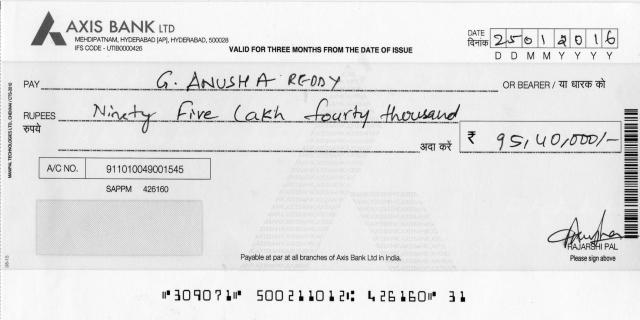

In [198]:
print(len(sample_ds))
sample_ds[0]

In [77]:
results = detect(model, one_ds, stream=False)

2024-02-15 11:23:43.345 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: False
2024-02-15 11:23:43.346 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: False
2024-02-15 11:23:43.347 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 1 samples



0: 640x640 1 amnt, 1 chk_no, 1 date, 1 micr, 1 orderof, 1 payee, 32.9ms
Speed: 3.6ms preprocess, 32.9ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)


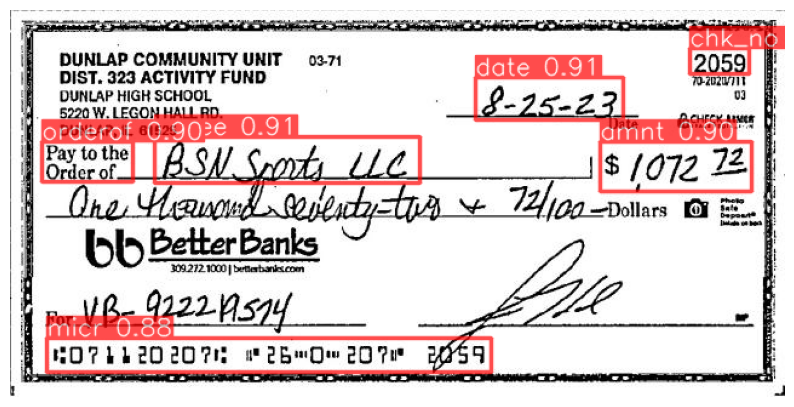

In [78]:
_ = results[0].draw(display=True)

In [200]:
results_doctr = detect(det_model_doctr, sample_ds, stream=False)

2024-02-14 16:02:02.842 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: False
2024-02-14 16:02:02.843 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: True
2024-02-14 16:02:02.844 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 5 samples


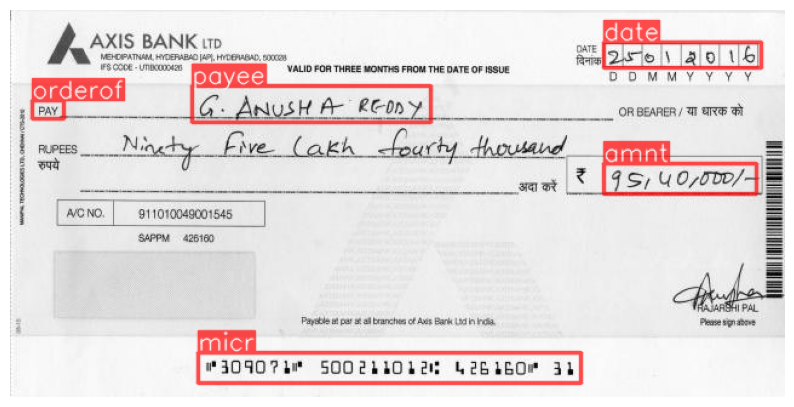

In [202]:
_ = results[0].draw(display=True, show_conf=False, show_label=True)

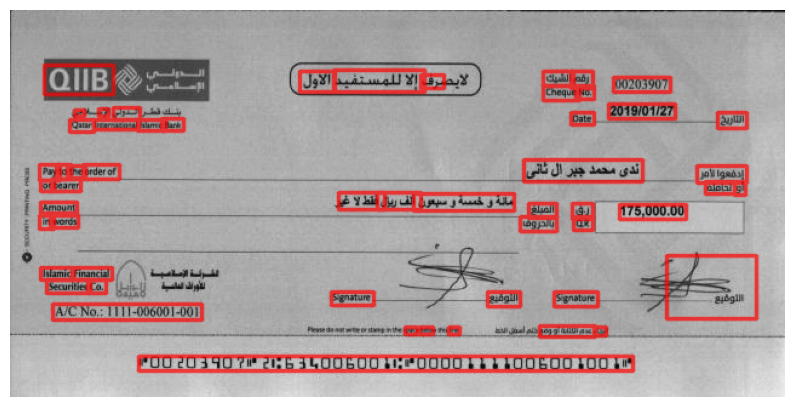

In [203]:
_ = results_doctr[3].draw(display=True, show_conf=False, show_label=False)

In [204]:
l_filter_by_cls = [result.filter_by_labels(["payee"]) for result in results]

### test filter by bbox

In [205]:
l_filter_by_cls

[[<chequeparser.wrappers.detection_results.DetectionResults at 0x7fadd60a5a90>],

In [240]:
l_boxes_inside_payee = [doctr_res.filter_by_bbox(res[0].bboxes[0], thresh=0.7) if len(res) > 0
                        else doctr_res.empty()
                        for doctr_res, res in zip(results_doctr, l_filter_by_cls)
                       ]

In [241]:
_ = [x.sort_bboxes_lr_() for x in l_boxes_inside_payee]

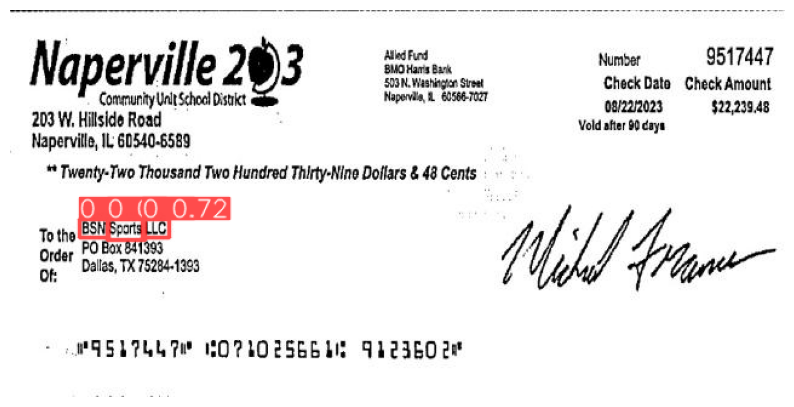

In [242]:
_ = l_boxes_inside_payee[4].draw(display=True)

In [243]:
payee_ds = concat_ds([result.create_ds() for result in l_boxes_inside_payee])

In [244]:
payee_ds.names

['0__X_085_jpeg_jpg.rf.37ea8d9ebfbb2ff715c21148b130d528.jpg',
 '0__X_085_jpeg_jpg.rf.37ea8d9ebfbb2ff715c21148b130d528.jpg',
 '0__X_085_jpeg_jpg.rf.37ea8d9ebfbb2ff715c21148b130d528.jpg',
 '0__X_074_jpeg_jpg.rf.308a150ac161e9e3a1226ce9e8c9d561.jpg',
 '0__X_074_jpeg_jpg.rf.308a150ac161e9e3a1226ce9e8c9d561.jpg',
 '0__191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg',
 '0__191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg',
 '0__191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg',
 '0__191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg',
 '0__0A3EF7A600C4423A9C0BD112C5D259A8_FACE_jpg.rf.2f080a3c9fec88f937b86870ffbc2674.jpg',
 '0__8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg',
 '0__8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg',
 '0__8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg']

### ocr

In [245]:
ocr_model = DoctrRecognize(arch=DOCTR_RECOG_PRETRAINED, path="crnn_vgg16_bn")

In [246]:
ocr_results = recognize(ocr_model, payee_ds, stream=False)

2024-02-14 16:15:46.920 | INFO     | chequeparser.core.recognizer:recognize:30 - Stream mode: False
2024-02-14 16:15:46.921 | INFO     | chequeparser.core.recognizer:recognize:31 - Batched mode: False
2024-02-14 16:15:46.922 | INFO     | chequeparser.core.recognizer:recognize:32 - Running predict on 13 samples


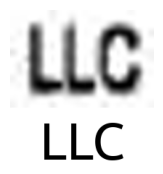

In [247]:
_ = ocr_results[12].draw(display=True)

In [248]:
len(ocr_results)

13

In [249]:
sizes = [len(r) for r in l_boxes_inside_payee]

In [250]:
part_ocr_results = partition_list(ocr_results, sizes)

In [251]:
for fname, l_res in zip(sample_ds.names, part_ocr_results):
    print(fname, " ".join([r.text for r in l_res]))

X_085_jpeg_jpg.rf.37ea8d9ebfbb2ff715c21148b130d528.jpg GANUSH A RGODY
X_074_jpeg_jpg.rf.308a150ac161e9e3a1226ce9e8c9d561.jpg KAwuha Chowdhasy
191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg PRIMARY PRODUCTS ING AMERICAS
0A3EF7A600C4423A9C0BD112C5D259A8_FACE_jpg.rf.2f080a3c9fec88f937b86870ffbc2674.jpg Jg
8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg BSN Sports LLC


In [254]:
max([3] + [1, 2])

3

## argparse test

In [138]:
import argparse


In [141]:
parser = argparse.ArgumentParser(description="Example Argument Parser")
parser.add_argument('--arg1', type=str, default="hola", help="Description of argument 1")
parser.add_argument('--arg2', type=int, help="Description of argument 2")
parser.add_argument('--flag', action='store_true', help="Flag argument")

_StoreTrueAction(option_strings=['--flag'], dest='flag', nargs=0, const=True, default=False, type=None, choices=None, help='Flag argument', metavar=None)

In [142]:
args = parser.parse_args("")

In [146]:
dict_args = vars(args)

In [148]:
mykwargs = {"arg1": "hello", "arg2": "blaha"}

In [149]:
dict_args.update(mykwargs)

In [152]:
args.flag

False

## trying out ppocr integration

In [38]:
from chequeparser.models import PPOCR_SVTR_LCNET

In [39]:
PPOCR_SVTR_LCNET??

Init signature:
PPOCR_SVTR_LCNET(
    path=None,
    device='cpu',
    model_kwargs: dict = None,
    **kwargs,
)
Docstring:      <no docstring>
Source:        
class PPOCR_SVTR_LCNET(metaclass=BaseArch):
    @staticmethod
    def load(path, device, model_kwargs, **kwargs):
        import chequeparser.integrations.paddleocr as framework

        return framework.load("rec", "SVTR_LCNet", path, device, model_kwargs, **kwargs)
File:           ~/workspace/chequeparser/src/chequeparser/models/arch.py
Type:           BaseArch
Subclasses:     

In [97]:
/

()

In [95]:
Path('/home/ajkdrag/workspace/chequeparser/venv/lib/python3.8/site-packages/paddleocr/ppocr/utils/dict/en_dict.txt').open().read()

'0\n1\n2\n3\n4\n5\n6\n7\n8\n9\na\nb\nc\nd\ne\nf\ng\nh\ni\nj\nk\nl\nm\nn\no\np\nq\nr\ns\nt\nu\nv\nw\nx\ny\nz\nA\nB\nC\nD\nE\nF\nG\nH\nI\nJ\nK\nL\nM\nN\nO\nP\nQ\nR\nS\nT\nU\nV\nW\nX\nY\nZ\n \n'

In [44]:
from paddleocr import PaddleOCR

In [98]:
model = PPOCR_SVTR_LCNET()

Reloading 'chequeparser.integrations.paddleocr'.


2024-02-26 19:46:51.759 | INFO     | chequeparser.utilities.network_utils:download_file:85 - Found /home/ajkdrag/.cache/ppocr/models/en_PP-OCRv4_rec_infer.tar. Skipping download.
2024-02-26 19:46:51.760 | INFO     | chequeparser.utilities.network_utils:download_file:106 - Found /home/ajkdrag/.cache/ppocr/models/en_PP-OCRv4_rec_infer. Skipping untar.
2024-02-26 19:46:51.763 | INFO     | chequeparser.integrations.paddleocr:load:76 - Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir=None, cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir=None, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det

In [8]:
from ppocr.utils.network import maybe_download, confirm_model_dir_url

In [7]:
maybe_download?

Signature: maybe_download(model_storage_directory, url)
Docstring: <no docstring>
File:      ~/workspace/chequeparser/venv/lib/python3.8/site-packages/paddleocr/ppocr/utils/network.py
Type:      function

In [10]:
from chequeparser.utilities.io_utils import extract_files

In [13]:
from chequeparser.utilities import download_file

Reloading 'chequeparser.utilities.network_utils'.


In [52]:
storage = download_file("https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_infer.tar", cache_subdir="ppocr/models/", untar=True)

2024-02-26 19:29:56.676 | INFO     | chequeparser.utilities.network_utils:download_file:85 - Found /home/ajkdrag/.cache/ppocr/models/en_PP-OCRv3_rec_infer.tar. Skipping download.
2024-02-26 19:29:56.677 | INFO     | chequeparser.utilities.network_utils:download_file:108 - Extracting to /home/ajkdrag/.cache/ppocr/models/en_PP-OCRv3_rec_infer
2024-02-26 19:29:56.680 | INFO     | chequeparser.utilities.io_utils:extract_files:23 - Extracted en_PP-OCRv3_rec_infer/inference.pdmodel ...
2024-02-26 19:29:56.680 | INFO     | chequeparser.utilities.io_utils:extract_files:23 - Extracted en_PP-OCRv3_rec_infer/inference.pdiparams.info ...
2024-02-26 19:29:56.691 | INFO     | chequeparser.utilities.io_utils:extract_files:23 - Extracted en_PP-OCRv3_rec_infer/inference.pdiparams ...


Reloading 'chequeparser.utilities.io_utils'.


In [25]:
storage

'/home/ajkdrag/.cache/ppocr/models/en_PP-OCRv3_rec_infer'

In [29]:
from ppocr.utils import dict as ppdict

In [33]:
import importlib_resources

In [30]:
vars(ppdict)

{'__name__': 'ppocr.utils.dict',
 '__doc__': None,
 '__package__': 'ppocr.utils.dict',
 '__loader__': <_frozen_importlib_external._NamespaceLoader at 0x7fce23796cd0>,
 '__spec__': ModuleSpec(name='ppocr.utils.dict', loader=<_frozen_importlib_external._NamespaceLoader object at 0x7fce23796cd0>, submodule_search_locations=_NamespacePath(['/home/ajkdrag/workspace/chequeparser/venv/lib/python3.8/site-packages/paddleocr/ppocr/utils/dict'])),
 '__file__': None,
 '__path__': _NamespacePath(['/home/ajkdrag/workspace/chequeparser/venv/lib/python3.8/site-packages/paddleocr/ppocr/utils/dict'])}

In [34]:
inp_file = (importlib_resources.files(ppdict) / 'en_dict.txt')

In [37]:
inp_file.open().read()

'0\n1\n2\n3\n4\n5\n6\n7\n8\n9\na\nb\nc\nd\ne\nf\ng\nh\ni\nj\nk\nl\nm\nn\no\np\nq\nr\ns\nt\nu\nv\nw\nx\ny\nz\nA\nB\nC\nD\nE\nF\nG\nH\nI\nJ\nK\nL\nM\nN\nO\nP\nQ\nR\nS\nT\nU\nV\nW\nX\nY\nZ\n \n'